In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

# Preliminaries

This notebook exposes the internals of TF-MoDISco. It uses importance scores that have been generated on the TAL GATA 3-task simulated dataset used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for how to generate the data used in this notebook.

## Setup

Gather all the necessary data for running TF-MoDISco

In [2]:
import numpy as np
import modisco
import tensorflow
print("Tensorflow version:",tensorflow.__version__)
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

Tensorflow version: 1.7.0
2.7.13 |Anaconda 2.4.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


### Grab the input data

In [3]:
!./grab_scores_for_modisco.sh

File scores.h5 exists already
File sequences.simdata.gz exists already
File test.txt.gz exists already


### One-hot encode the fasta sequences

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

### Load importance scores into numpy arrays

You need a numpy array of importance scores and hypothetical importance scores for every task. See `Generate Importance Scores.ipynb` for how to prepare these data tracks.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]

### Double check data by plotting

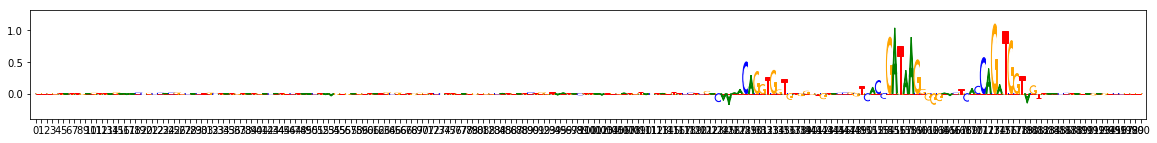

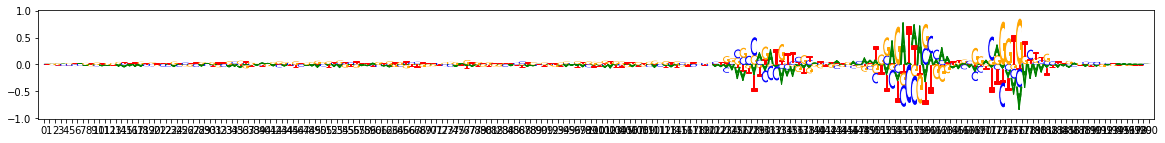

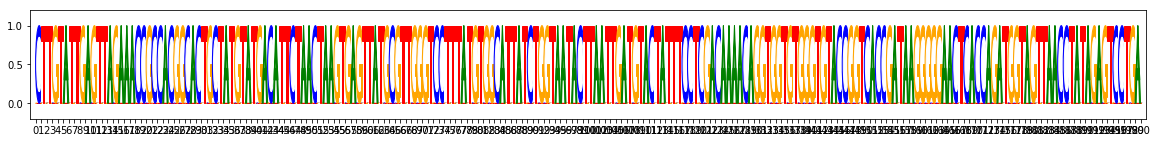

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

# TF-MoDISco internals

Here, we expose the internals of what happens when one calls an instance of `modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow`

## Phase 1: Seqlet Identification and Metaclustering

### Phase 1, part a: Seqlet identification

We first identify a list of seqlets across all tasks. To do this, we first compute the per-position contributions for each task (i.e. the contributions summed up over the ACGT channel axis).

In [7]:
from collections import OrderedDict, Counter

task_names=["task0", "task1", "task2"]
#Compute the contributions at each position, for each task
per_position_contrib_scores = OrderedDict([                             
                                (x, np.sum(task_to_scores[x],axis=2))
                                for x in task_names])

For each task, we pass the per-position contributions to the `FixedWindowAroundChunks` coordinate producer, which identifies candidate coordinates to use for as follows:
- For each task, the importance scores are summed in sliding windows of core size `sliding_window_size`.
- The mode is identified, and the scores are centered around the mode. A one-tailed laplace distribution is fit to the 5th percentile of positive scores, and another one-tailed laplace distribution is fit to the 5th percentile of the absolute value of the negative scores. We will use these laplace distributions to estimate False Discovery Rates under the assumption that scores with low magnitudes are mostly noise. I chose to use different laplace distributions for positive and negative scores in case the positive and negative noise have different distributions.
- Based on the laplace distribution, FDRs are estimated for each value as [expected number of noise hits above value]/[actual number of hits above value]. The threshold corresponding to a target FDR of `target_seqlet_fdr` is identified.
     - If no such threshold exists, the most extreme value in the distribution is used as the threshold.
- If the total number of windows with a sum that passes the positive and negative thresholds is less than `min_seqlets`, the positive and negative thresholds are recalculated by sorting the windows in descending order of absolute value and picking a threshold such that the number of passing windows (in terms of absolute value) is `min_seqlets`. The negative threshold is then set to be the minus of the positive threshold. Note that the actual number of seqlets is likely to be smaller than this number after overlapping windows are removed.
- After the final threshold is determined, all windows with a sum that does not pass the threshold are filtered out.
- The following process is then repeated for each sequence:
    - Identify the window with the highest magnitude
    - Expand the window on either side by flank size `flank_size`. These coordinates will be used to make a seqlet.
    - Filter out all windows that would overlap this by over 50% (after flank expansion)

#####
ON TASK task0 
######
Computing windowed sums
Computing threshold
peak(mu)= -0.024238264271989465
Mu: -2.423826e-02 +/- 5.063778e-06
Lablace_b: 0.15164182366673082 and 0.21323786117475912
Thresholds: -1.5073591825459152 and 1.2725672367122025
#fdrs pass: 0 and 19793
CDFs: 0.999943452031181 and 0.9977152471273854
Est. FDRs: 1.0 and 0.00999113540721059


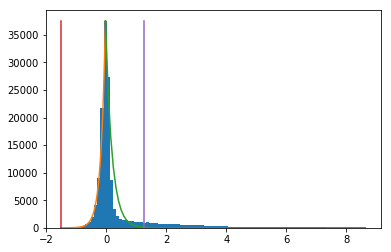

Got 1371 coords
#####
ON TASK task1 
######
Computing windowed sums
Computing threshold
peak(mu)= 0.005545238786377013
Mu: 5.545239e-03 +/- 5.741705e-06
Lablace_b: 0.1412717956920302 and 0.11624143409064712
Thresholds: -1.7306354243224487 and 0.7122924130493775
#fdrs pass: 0 and 15512
CDFs: 0.9999954008918504 and 0.9977118086817763
Est. FDRs: 0.3727485624294786 and 0.009994167375583403


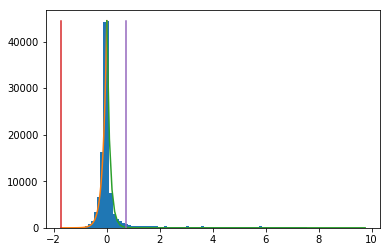

Got 1069 coords
#####
ON TASK task2 
######
Computing windowed sums
Computing threshold
peak(mu)= -0.011790548293385654
Mu: -1.179055e-02 +/- 7.010704e-06
Lablace_b: 0.1150758068659872 and 0.12597872040434585
Thresholds: -1.625360642401967 and 0.7686457290961407
#fdrs pass: 0 and 16462
CDFs: 0.9999991864034751 and 0.9979603661115659
Est. FDRs: 0.05563206652232111 and 0.009964247323977026


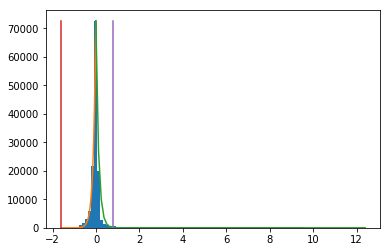

Got 1009 coords


In [8]:
from modisco import coordproducers

sliding_window_size = 15
flank_size = 5
target_seqlet_fdr = 0.01
min_seqlets=500

#Instantiate the coordinate producer
coord_producer = coordproducers.FixedWindowAroundChunks(           
                        sliding=sliding_window_size,                                   
                        flank=flank_size,                                              
                        thresholding_function=coordproducers.LaplaceThreshold(              
                                                    target_fdr=target_seqlet_fdr,
                                                    min_seqlets=min_seqlets,
                                                    verbose=True))

#Call the coordinate producer on per-position contribution scores for each task
task_name_to_coord_producer_results = OrderedDict() 
for task_name in per_position_contrib_scores:           
    print("#####\nON TASK",task_name,"\n######")                   
    score_track = per_position_contrib_scores[task_name]
    coord_producer_results = coord_producer(score_track=score_track)
    #Given the coordinates, seqlets can be created by retrieving the
    # necessary data from the TrackSet
    task_name_to_coord_producer_results[task_name] = coord_producer_results 


Once we have the coordinates, we can create the seqlets by retrieving the data at those coordinates. Before we do this, we have to first wrap the data in instances of `modisco.core.DataTrack`, and collect all the DataTrack objects into an an instance of `modisco.core.TrackSet`

In [9]:
from modisco import core

contrib_scores_tracks = [core.DataTrack(name=key+"_contrib_scores",                                     
                                        fwd_tracks=task_to_scores[key],                                 
                                        rev_tracks=[x[::-1, ::-1] for x in                              
                                                    task_to_scores[key]],                               
                                        has_pos_axis=True) for key in task_names]
hypothetical_contribs_tracks = [core.DataTrack(name=key+"_hypothetical_contribs",                   
                                               fwd_tracks=task_to_hyp_scores[key],               
                                               rev_tracks=[x[::-1, ::-1] for x in                   
                                                            task_to_hyp_scores[key]],            
                                               has_pos_axis=True) for key in task_names]                 
onehot_track = core.DataTrack(name="sequence", fwd_tracks=onehot_data,                
                              rev_tracks=[x[::-1, ::-1] for x in onehot_data],        
                              has_pos_axis=True)
track_set = core.TrackSet(data_tracks=contrib_scores_tracks                       
                          +hypothetical_contribs_tracks+[onehot_track])

Once we have the TrackSet, we can create the seqlets for each task:

In [10]:
task_name_to_seqlets = OrderedDict()
for task_name in task_name_to_coord_producer_results:
    coord_producer_results = task_name_to_coord_producer_results[task_name]
    task_name_to_seqlets[task_name] = track_set.create_seqlets(
                                        coords=coord_producer_results.coords)

We now take the union of seqlets across all tasks. If a seqlet overlaps with another seqlet by > `overlap_portion`, the lower-scoring seqlet is dropped.

In [11]:
import itertools

overlap_portion = 0.5
#Create a class that resolves overlaps. overlap_detector
# specifies how to decide if seqlets are overlapping, and
# seqlet_comparator specifies how to pick between
# seqlets that are deemed to be overlapping.
overlap_resolver = core.SeqletsOverlapResolver(                    
            overlap_detector=core.CoordOverlapDetector(overlap_portion),   
            seqlet_comparator=core.SeqletComparator(                            
                                value_provider=lambda x: x.coor.score))

#take the union over everything, resolving overlaps as specified
# by overlap_resolver
final_seqlets = overlap_resolver(itertools.chain(*task_name_to_seqlets.values()))

### Phase 1, part b: Metaclustering

Seqlets are now clustered into metaclusters according to their contribution scores across tasks. The contribution of a seqlet to a particular task is taken to be the total per-position contribution score for that task in the central `sliding_window_size` bp of the seqlet. However, before we can cluster these scores across tasks, it is necessary to transform the scores such that scores from different tasks are comparable (by this, we mean that the scores for different tasks can be on different scales depending on the confidence of the model in that particular task, so some kind of normalization is needed). We do this transformation using the Laplace distributions that were calculated in Phase 1, part a; we replace each score with the CDF of the corresponding one-tailed laplace distribution and apply a negative sign if the original score was negative (so, an extreme positive score would get transformed to +1.0, and an extreme negative score would get transformed to -1.0). This transformation is handled by the class `modisco.core.LaplaceCdf`, as shown below:


In [12]:

task_name_to_value_provider = OrderedDict()

for task_name in per_position_contrib_scores:
    #retrieve the coord_producer_results for that task, which contains
    # information on the Laplace distributions that were fit
    coord_producer_results = task_name_to_coord_producer_results[task_name]
    #Instantiate a score transformer corresponding to the laplace
    # distribution of the task
    score_transformer = core.LaplaceCdf(
                            track_name=task_name+"_contrib_scores",                         
                            central_window=sliding_window_size)
    score_transformer.fit(coord_producer_results)
    task_name_to_value_provider[task_name] = score_transformer


The metaclustering strategy relies on matching seqlets to “activity patterns” using strong and weak thresholds, as described below.

We first define `strong_threshold` and `weak_threshold` for considering a seqlet to have a "high" contribution to a particular task. `strong_threshold` is taken to be the CDF corresponding to the most lenient threshold used during per-task seqlet identification; this ensures that every seqlet has a "strong" contribution to at least one task. `weak_threshold` is defined by the user, but it is constrained to be less than or equal to `strong_threshold`.

We now define an “activity pattern” as a sequence of plus/minus/0 for each task. 3 tasks implies 27 possible activity patterns. A seqlet is a “strong” plus for a task if the transformed score for that task is >= strong_threshold, and is a “strong” minus if the transformed score is <= -strong_threshold. Analogously for a seqlet being a “weak” plus or minus for a task.

We define an activity pattern to be "strongly compatible" with a seqlet if, for every task, the seqlet either matches the activity pattern according to the strong threshold, or the activity pattern is a 0 for the task (0 is best understood as indicating "no constraint on the task"). An analogous definition is used for "weakly compatible".

The metaclustering then proceeds as follows:
- For each activity pattern, count the number of “strongly compatible” seqlets
- Filter out activity patterns that have fewer than `min_metacluster_size` strongly compatible seqlets.
- Map each seqlet to the *most specific* activity pattern (that is, the activity pattern with the fewest zeros) with which it is weakly compatible. If a seqlet is compatible with two activity patterns of equal specificity, it is assigned to the one for which it has the higher absolute transformed score.

Strong threshold for counting sign is 0.9977118086817763
4 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [0, 0, 0, 0]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,1'}
Metaclusters heatmap


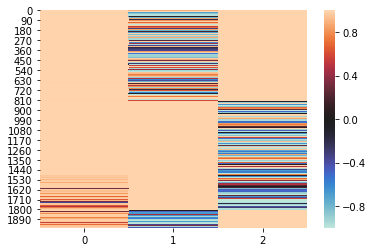

In [13]:
%matplotlib inline
from modisco import metaclusterers

weak_threshold_for_counting_sign = 0.99
min_metacluster_size = 100

#Set strong_threshold_for_counting_sign to the most
# lenient laplace cdf threshold used across all tasks
strong_threshold_for_counting_sign = min(
    [min(x.thresholding_results.pos_threshold_cdf,
         x.thresholding_results.neg_threshold_cdf)
         for x in task_name_to_coord_producer_results.values()])
print("Strong threshold for counting sign is "
      +str(strong_threshold_for_counting_sign))

# Make sure weak_threshold_for_counting_sign is <=
# strong_threshold_for_counting_sign
weak_threshold_for_counting_sign = min(weak_threshold_for_counting_sign,
                                       strong_threshold_for_counting_sign)

#Perform the metaclustering
metaclusterer = metaclusterers.SignBasedPatternClustering(
                        task_name_to_value_provider=
                         task_name_to_value_provider,
                        task_names=task_names,
                        min_cluster_size=min_metacluster_size,
                        threshold_for_counting_sign=
                            strong_threshold_for_counting_sign,
                        weak_threshold_for_counting_sign=
                            weak_threshold_for_counting_sign)
metaclustering_results = metaclusterer.fit_transform(final_seqlets)
metacluster_indices = metaclustering_results.metacluster_indices

#Print out general summary info about the metaclusters
metacluster_idx_to_activity_pattern =\
    metaclustering_results.metacluster_idx_to_activity_pattern
num_metaclusters = max(metacluster_indices)+1
metacluster_sizes = [np.sum(metacluster_idx==metacluster_indices)
                      for metacluster_idx in range(num_metaclusters)]
print("Metacluster sizes: ",metacluster_sizes)
print("Idx to activities: ",metacluster_idx_to_activity_pattern)
print("Metaclusters heatmap")
from matplotlib import pyplot as plt
import seaborn as sns
activity_patterns = metaclustering_results.attribute_vectors[
                        np.array([x[0] for x in sorted(
                                 enumerate(metacluster_indices),
                                 key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

## Phase 2: clustering within a metacluster

We now perform clustering within each metacluster to find the motifs. For simplicity, we will just show results with a single metacluster (metacluster 3) here. The actual `TfMoDIScoWorkflow` class loops over all metaclusters.

### Gather relevant data for the metacluster

We begin by gathering the seqlets of the metacluster together and identifying which tasks are relevant (i.e. nonzero) for the metacluster's activity pattern

In [14]:
metacluster_idx = 3

#Gather the metacluster seqlets together
metacluster_seqlets = [x[0] for x in zip(final_seqlets, metacluster_indices)
                       if x[1]==metacluster_idx]

print("On metacluster "+str(metacluster_idx))
print("Metacluster size", len(metacluster_seqlets))

#Identify the tasks that are relevant for the metacluster's
# activity pattern
metacluster_activities = [
    int(x) for x in
    metacluster_idx_to_activity_pattern[metacluster_idx].split(",")]
relevant_task_names, relevant_task_signs =\
    zip(*[(x[0], x[1]) for x in
        zip(task_names, metacluster_activities) if x[1] != 0])
print('Relevant tasks: ', relevant_task_names)
print('Relevant signs: ', relevant_task_signs)

#Gather together all the track names corresponding to the
# relevant tasks
onehot_track_name="sequence"
contrib_scores_track_names =\
    [key+"_contrib_scores" for key in relevant_task_names]
hypothetical_contribs_track_names=\
    [key+"_hypothetical_contribs" for key in relevant_task_names]

#For deterministic results, we also sort the seqlets into a
# deterministic order
seqlets_sorter = (lambda arr:
                  sorted(arr, key=lambda x:
                                  -np.sum([np.sum(np.abs(x[track_name].fwd)) 
                                     for track_name
                                     in contrib_scores_track_names])))
seqlets = seqlets_sorter(metacluster_seqlets)

On metacluster 3
Metacluster size 158
Relevant tasks:  ('task2',)
Relevant signs:  (1,)


### Execute a round of clustering

Each round of clustering consists of the following steps:
- Coarse-grained affinity matrix calculation
- Fine-grained affinity matrix calculation on nearest-neighbors identified by the coarse-grained calculation
- Transforming the affinity matrix to account for the local density of the data
- Further transforming the affinity matrix using Louvain community detection co-occurrence statistics over multiple random seeds
- Performing one round of Louvain community detection on the final transformed affinity matrix
- Aggregating motifs within each cluster

#### Coarse-grained affinity matrix calculation

Because the fine-grained affinity matrix is expensive to compute, we speed up the process by computing a coarse-grained affinity matrix and then computing fine-grained similarities only between points that are deemed to be close by the coarse-grained affinity matrix.

For the coarse-grained affinity matrix, a gapped kmer embedding is derived for each seqlet, and the cosine distance between seqlet embeddings is used as the affinity (credit to Anna Shcherbina for this idea). Note that this aspect of the workflow is highly specific to DNA sequence, and would have to be replaced with another way of computing affinity matrices if the user wishes to cluster patterns that are not DNA sequence. The gapped kmer embedding proceeds as follows:
- For each seqlet, a single hypothetical contributions track is created by taking the sum of the hypothetical contributions for the tasks that are relevant for the metacluster's activity pattern. If a task is negative in the activity pattern, the hypothetical contributions are multiplied by -1 before being added to the sum.
- Gapped kmers (potentially allowing for mismatches) are identified in the seqlet by scanning the one-hot encoded sequence.
- For each gapped kmer match, the "score" of the match is taken to be the dot product of the one-hot encoded representation of the gapped kmer and the portion of the summed hypothetical contributions track that it overlaps.
- A total score for each gapped kmer is computed by summing the scores over all matches for that gapped kmer in the seqlet. This vector of total scores serves as the embedding.

For efficiency, the gapped kmer scoring is implemented using convolutional operation on the GPU.

In [15]:
from modisco import affinitymat

kmer_len = 5
num_gaps = 1
num_mismatches = 0

#Define the gapped kmer embedder
gkmer_embedder = affinitymat.core.GappedKmerEmbedder(
    alphabet_size=4, kmer_len=kmer_len,
    num_gaps=num_gaps, num_mismatches=num_mismatches,
    batch_size=20, num_filters_to_retain=None,
    onehot_track_name=onehot_track_name,
    toscore_track_names_and_signs=list(
        zip(hypothetical_contribs_track_names,
            [np.sign(x) for x in relevant_task_signs])),
    normalizer=affinitymat.core.MeanNormalizer())

#Define a coarse-grained affinity matrix calculator that
# relies on the cosine similarity between embeddings
coarse_affmat_computer =\
    affinitymat.core.AffmatFromSeqletEmbeddings(
        seqlets_to_1d_embedder=gkmer_embedder,
        affinity_mat_from_1d= affinitymat.core.NumpyCosineSimilarity(
                                verbose=True,gpu_batch_size=None),
        verbose=True)
    
#compute the coarse-grained affinity matrix
coarse_affmat = coarse_affmat_computer(seqlets)

Beginning embedding computation
Computing embeddings
Finished embedding computation in 1.93 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s


Using TensorFlow backend.


#### Fine-grained affinity matrix calculation on nearest neighbors

The fine-grained affinity matrix uses the Continuous Jaccard similarity as described in [this talk](https://www.youtube.com/watch?v=fXPGVJg956E). Affinities are computed only on the `nearest_neighbors_to_compute` nearest neighbors of each seqlet identified by the coarse-grained affinity matrix calculation; affinities are set to zero otherwise. For each seqlet, the Continuous Jaccard similarity is computed on the concatenation of the hypothetical and actual contribution tracks for all relevant tasks. Each seqlet's track is normalized to have an L1 norm of 1 prior to concatenation. For each pair of seqlets, the Continuous Jaccard similarity is computed at all alignments that overlap by at least `min_overlap_while_sliding` of the total seqlet length. Zero-padding is used to deal with overhangs. The maximum similarity over all computed alignments is taken to be the affinity between the pair.

In [16]:
from modisco import nearest_neighbors

min_overlap_while_sliding = 0.7
nearest_neighbors_to_compute = 500

#Get nearest neighbors
nearest_neighbors_computer = nearest_neighbors.ScikitNearestNeighbors(
            n_neighbors=nearest_neighbors_to_compute,
            nn_n_jobs=4)
seqlet_neighbors = nearest_neighbors_computer(coarse_affmat)

#Compute fine-grained affmat on nearest neighbors
pattern_comparison_settings =\
            affinitymat.core.PatternComparisonSettings(
                track_names=hypothetical_contribs_track_names
                            +contrib_scores_track_names,
                track_transformer=affinitymat.L1Normalizer(),
                min_overlap=min_overlap_while_sliding)
affmat_from_seqlets_with_nn_pairs =\
            affinitymat.core.AffmatFromSeqletsWithNNpairs(
                pattern_comparison_settings=pattern_comparison_settings,
                sim_metric_on_nn_pairs=\
                    affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                        n_cores=4,
                        cross_metric_single_region=
                            affinitymat.core.CrossContinJaccardSingleRegion()))
nn_affmat = affmat_from_seqlets_with_nn_pairs(
                seqlet_neighbors=seqlet_neighbors, seqlets=seqlets)

Launching nearest neighbors affmat calculation job
Job completed in: 1.02 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.95 s


To be on the safe side, we can filter out seqlets where the correlation between the coarse-grained affinity matrix and fine-grained affinity matrix is poor, since the affinities for those seqlets may be unreliable. This step is optional.

In [17]:
#affmat_correlation_threshold defines the minimum desired
# spearman correlation between the coarse-grained and
# fine-grained affinity matrix.
affmat_correlation_threshold = 0.15

#Filter out things that have poor correlation between
#the fine-grained and coarse-grained
filtered_rows_mask = affinitymat.core.FilterMaskFromCorrelation(
                correlation_threshold=affmat_correlation_threshold,
                verbose=False)(main_affmat=nn_affmat,
                              other_affmat=coarse_affmat)
filtered_seqlets = [x[0] for x in
                    zip(seqlets, filtered_rows_mask) if (x[1])]
filtered_affmat = nn_affmat[filtered_rows_mask][:,filtered_rows_mask]
print("Retained "+str(np.sum(filtered_rows_mask))
      +" rows out of "+str(len(filtered_rows_mask))
      +" after filtering")

Retained 138 rows out of 158 after filtering


#### Transforming the affinity matrix to account for local density

We transform the affinity matrix to take into account the local density of the data such that points in densely-packed regions of the space are more stringent about what they consider similar. To do this, we can leverage a conditional probability transformation similar to what is used in the first step of t-sne, as described in [this talk](https://www.youtube.com/watch?v=fXPGVJg956E). This transformation uses a distance matrix, so we will need to specify a function to map from affinities to distances. We use the transformation:

`distance = log(1.0/0.5*max(affinity, 0) - 1)`

This transformation gives a distance of 0 when the affinity is 1, and a distance of infinity when the affinity is <= 0. The particular choice of function was based on heuristics and may be revised in the future.

The choice of `tsne_perplexity` controls how stringent we are about considering things to be "close by". Think of it as roughly analogous to the size of the neighborhood of each point.

In [18]:
tsne_perplexity = 30

#function specifying how to map from affinities to distances
aff_to_dist_mat=affinitymat.transformers.AffToDistViaLogInv()

#adapt using t-sne conditional probs
density_adapted_affmat_transformer =\
    affinitymat.transformers.TsneConditionalProbs(
        perplexity=tsne_perplexity,
        aff_to_dist_mat=aff_to_dist_mat)
density_adapted_affmat = density_adapted_affmat_transformer(filtered_affmat)

#Symmetrize the density-adapted affinity matrix by adding it to
# its transpose and dividing by 2. This is done in t-sne 
density_adapted_affmat = affinitymat.transformers.SymmetrizeByAddition(  
                            probability_normalize=True)(density_adapted_affmat)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.000s...
[t-SNE] Computed neighbors for 138 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 0.314447


#### Computing co-occurrence over several Louvain rounds

Louvain community detection is a clustering algorithm that does not require the user to pre-specify the number of clusters; rather, the number of clusters is determined automatically according to what optimizes a quantity called the "modularity". Unfortunately, Louvain community detection results can be sensitive to the choice of random seed. To improve the stability of the results, we run Louvain community detection `louvain_membership_average_n_runs` times and compute a new affinity matrix where the affinity between two seqlets is the number of times they appeared in the same Louvain cluster. When doing the community detection, we supply the density-adpated affinities.

Note that to introduce deterministic results based on random seeds, I had to modify the Louvain community detection executable. The code for the modified executable is at https://github.com/kundajelab/modisco_louvain. 

In [19]:
louvain_membership_average_n_runs = 200
#get the co-occurrence matrix aggregated over several
# rounds of Louvain community detection with different
# random seeds.
louvain_averaged_affmat =\
    affinitymat.transformers.LouvainMembershipAverage(              
        n_runs=louvain_membership_average_n_runs, 
        #Louvain community detection computes heirarchical
        # clusters. We speciy that we want the top-most
        # level of the heirarcy
        level_to_return=-1,                            
        parallel_threads=4)(density_adapted_affmat)


Wrote graph to binary file in 0.0152299404144 seconds
Running Louvain modularity optimization


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.5s finished


Louvain completed 200 runs in 7.09099006653 seconds


#### Running Louvain on the Louvain co-occurrence statistics

We now run Louvain community detection on the Louvain co-occurrence statistics.

In [20]:
from modisco import cluster

cluster_results = cluster.core.LouvainCluster( 
    #Louvain community detection computes heirarchical
    # clusters. Here, we just want the bottom-most level
    # of the heirarchy
    level_to_return=1,                 
    affmat_transformer=None,
    #We try different random seeds and terminate after no
    # improvement has been observed for the last 50
    # random seeds that were tried.
    contin_runs=50,                            
    verbose=True)(louvain_averaged_affmat)

num_clusters = max(cluster_results.cluster_indices+1)
cluster_idx_counts = Counter(cluster_results.cluster_indices)
print("Got "+str(num_clusters)+" clusters")
print("Counts:")
print(dict([x for x in cluster_idx_counts.items()]))

Beginning preprocessing + Louvain
Wrote graph to binary file in 0.0128710269928 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.464581
Louvain completed 51 runs in 4.15661907196 seconds
Preproc + Louvain took 4.17902088165 s
Got 4 clusters
Counts:
{0: 70, 1: 39, 2: 25, 3: 4}


#### Aggregating seqlets in each cluster

WRITEME

After expansion and editing, the aggregated motif's contribution score pattern may disagree with that of the activity pattern of the metacluster. This is typically the result of noise at the edges of motifs. We filter these motifs out.

In [21]:
from collections import defaultdict
from modisco import aggregator

#Gather the seqlets that belong to each cluster
cluster_to_seqlets = defaultdict(list)
for seqlet,idx in zip(filtered_seqlets,
                      cluster_results.cluster_indices):
    cluster_to_seqlets[idx].append(seqlet)

#define something that does aggregation for each seqlet set
seqlet_aggregator = aggregator.GreedySeqletAggregator(                  
    pattern_aligner=core.CrossContinJaccardPatternAligner(  
        #pattern_comparison_settings were defined in an
        # earlier cell
        pattern_comparison_settings=pattern_comparison_settings),       
        seqlet_sort_metric=                                             
            lambda x: -sum([np.sum(np.abs(x[track_name].fwd)) for       
                       track_name in contrib_scores_track_names]),      
    postprocessor=None)

frac_support_to_trim_to = 0.2
min_num_to_trim_to = 30
trim_to_window_size = 15
initial_flank_to_add = 5
postprocessor=(aggregator.TrimToFracSupport(                                       
                min_frac=frac_support_to_trim_to,                  
                min_num=min_num_to_trim_to,                        
                verbose=True)                                 
               .chain(aggregator.ExpandSeqletsToFillPattern(                              
                        track_set=track_set,                                            
                        flank_to_add=initial_flank_to_add).chain(                  
                     aggregator.TrimToBestWindow(                                        
                        window_size=trim_to_window_size,                           
                        track_names=contrib_scores_track_names)).chain(                 
                     aggregator.ExpandSeqletsToFillPattern(                              
                        track_set=track_set,                                            
                        flank_to_add=initial_flank_to_add))))

def sign_consistency_func(motif):                                       
    motif_track_signs = [                                               
        np.sign(np.sum(motif[contrib_scores_track_name].fwd)) for       
        contrib_scores_track_name in contrib_scores_track_names]        
    return all([(x==y) for x,y in zip(motif_track_signs, 
                                      relevant_task_signs)])

cluster_to_eliminated_motif = OrderedDict()
cluster_to_motif = OrderedDict()
for i in range(num_clusters):
    print("Aggregating for cluster "+str(i)+" with "
          +str(len(cluster_to_seqlets[i]))+" seqlets")
    motif = postprocessor(seqlet_aggregator(cluster_to_seqlets[i]))[0]
    if (sign_consistency_func(motif)):
        cluster_to_motif[i] = motif
    else:
        print("Dropping cluster "+str(i)+
              " with "+str(motif.num_seqlets)
              +" seqlets due to sign disagreement")
        cluster_to_eliminated_motif[i] = motif

#obtain unique seqlets from adjusted motifs
seqlets = dict([(y.exidx_start_end_string, y)
                 for x in cluster_to_motif.values()
                 for y in x.seqlets]).values()


Aggregating for cluster 0 with 70 seqlets
Trimmed 7 out of 70
Skipped 6 seqlets
Aggregating for cluster 1 with 39 seqlets
Trimmed 5 out of 39
Skipped 1 seqlets
Aggregating for cluster 2 with 25 seqlets
Trimmed 1 out of 25
Skipped 7 seqlets
Aggregating for cluster 3 with 4 seqlets
Trimmed 0 out of 4


### Looping for additional iterations

During the aggregation step, the ends of seqlets are adjusted to align with the other seqlets in the motif. These adjusted seqlets could be put through another round of affinity matrix calculation and clustering, as they may result in even higher-quality motif. In the current implementation, the default is to do two rounds. For simplicity, we won't do an additional round here.


## Post-processing of clusters

Post-processing consists of the following steps:
- Identifying spurious merging (i.e. identifying clusters that should be split into subclsuters)
- Merging redundant patterns
- Reassign seqlets from small clusters to the dominant clusters
- Final expanding of the flanks

### Identifying spurious merging

WRITEME

In [22]:
           
print("Got "+str(len(cluster_to_motif.values()))+" clusters")
print("Splitting into subclusters...")

threshold_for_spurious_merge_detection = 0.8
final_min_cluster_size = 60
spurious_merge_detector = aggregator.DetectSpuriousMerging(             
            track_names=contrib_scores_track_names,                             
            track_transformer=affinitymat.core.L1Normalizer(),                  
            affmat_from_1d=affinitymat.core.ContinJaccardSimilarity(            
                            make_positive=True, verbose=False),                 
            diclusterer=cluster.core.LouvainCluster(                            
                            level_to_return=1,                                  
                            max_clusters=2, contin_runs=20,                     
                            verbose=False),                                     
            is_dissimilar_func=aggregator.PearsonCorrIsDissimilarFunc(          
                        threshold=threshold_for_spurious_merge_detection,  
                        verbose=True),                                  
            min_in_subcluster=final_min_cluster_size)
split_patterns = spurious_merge_detector(
                    cluster_to_motif.values())

Got 4 clusters
Splitting into subclusters...


### Merge redundant patterns

WRITEME

In [23]:
#Now start merging patterns 
print("Merging on "+str(len(split_patterns))+" clusters")

pattern_to_seqlet_sim_computer =(                                       
    affinitymat.core.AffmatFromSeqletsWithNNpairs(
        #pattern_comparison_settings were defined in
        # and earlier cell
        pattern_comparison_settings=pattern_comparison_settings,        
        sim_metric_on_nn_pairs=
            affinitymat.core.ParallelCpuCrossMetricOnNNpairs(           
                n_cores=4,                                   
                cross_metric_single_region=                          
                    affinitymat.core.CrossContinJaccardSingleRegion(),  
                verbose=False)))

prob_and_pertrack_sim_merge_thresholds=[                 
    (0.0001,0.84), (0.00001, 0.87), (0.000001, 0.9)]
prob_and_pertrack_sim_dealbreaker_thresholds=[           
    (0.1,0.75), (0.01, 0.8), (0.001, 0.83),(0.0000001,0.9)]
    
similar_patterns_collapser = aggregator.DynamicDistanceSimilarPatternsCollapser(                 
    pattern_to_pattern_sim_computer=                                
        pattern_to_seqlet_sim_computer,
    #aff_to_dist_mat was defined in an earlier cell
    aff_to_dist_mat=aff_to_dist_mat,                                
    pattern_aligner=core.CrossCorrelationPatternAligner(            
        pattern_comparison_settings=                                
            affinitymat.core.PatternComparisonSettings(             
                track_names=contrib_scores_track_names,                  
                track_transformer=                                  
                    affinitymat.MeanNormalizer().chain(             
                    affinitymat.MagnitudeNormalizer()),             
                min_overlap=min_overlap_while_sliding)),       
    collapse_condition=(lambda dist_prob, aligner_sim:              
        any([(dist_prob > x[0] and aligner_sim > x[1]*(
                        len(contrib_scores_track_names)))              
             for x in prob_and_pertrack_sim_merge_thresholds])),             
    dealbreaker_condition=(lambda dist_prob, aligner_sim:           
        any([(dist_prob < x[0] and aligner_sim < x[1]*(
                        len(contrib_scores_track_names)))              
             for x in prob_and_pertrack_sim_dealbreaker_thresholds])),       
    postprocessor=postprocessor,                                   
    verbose=True)

merged_patterns, pattern_merge_hierarchy =\
    similar_patterns_collapser(
        patterns=split_patterns, seqlets=seqlets)
    
merged_patterns = sorted(merged_patterns, key=lambda x: -x.num_seqlets) 
print("Got "+str(len(merged_patterns))+" patterns after merging")

Merging on 4 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 1 with prob 0.0007380119737361481 and sim 0.9781657571746373
Trimmed 3 out of 90
Skipped 2 seqlets
On merging iteration 2
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 3 patterns after merging


### Reassign seqlets from small clusters to the dominant clusters

WRITEME

In [24]:
print("Performing seqlet reassignment")

min_similarity_for_seqlet_assignment=0.2
seqlet_reassigner = (
    aggregator.ReassignSeqletsFromSmallClusters(                         
        seqlet_assigner=aggregator.AssignSeqletsByBestMetric( 
            #pattern_comparison_settings were defined in an
            # earlier cell
            pattern_comparison_settings=pattern_comparison_settings,        
            individual_aligner_metric=                                      
                core.get_best_alignment_crosscontinjaccard,                 
            matrix_affinity_metric=                                         
                affinitymat.core.CrossContinJaccardMultiCoreCPU(            
                    verbose=True, n_cores=4),            
            min_similarity=min_similarity_for_seqlet_assignment),      
        min_cluster_size=final_min_cluster_size,                       
        postprocessor=aggregator.ExpandSeqletsToFillPattern(                              
                        track_set=track_set,                                            
                        flank_to_add=initial_flank_to_add).chain(                  
                      aggregator.TrimToBestWindow(                                        
                        window_size=trim_to_window_size,                           
                        track_names=contrib_scores_track_names)).chain(                 
                      aggregator.ExpandSeqletsToFillPattern(                              
                        track_set=track_set,                                            
                        flank_to_add=initial_flank_to_add)),                                  
        verbose=True))
reassigned_patterns = seqlet_reassigner(merged_patterns)

Performing seqlet reassignment
Cross contin jaccard time taken: 0.39 s
Cross contin jaccard time taken: 0.46 s
Discarded 2 seqlets


#### Final expanding of the flanks

WRITEME

Skipped 1 seqlets
Got 1 patterns after reassignment
Task 0 hypothetical scores:


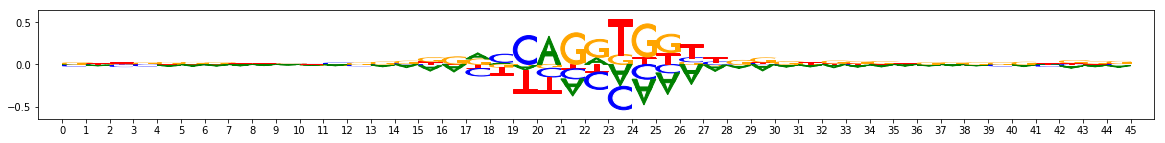

Task 0 actual importance scores:


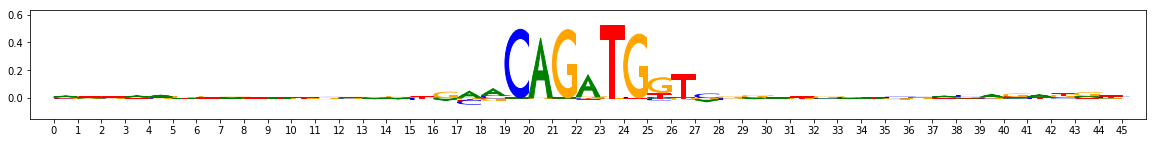

Task 1 hypothetical scores:


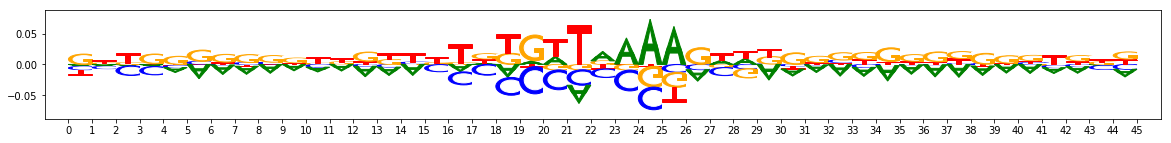

Task 1 actual importance scores:


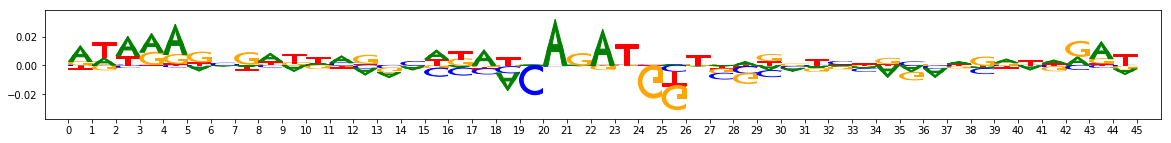

Task 2 hypothetical scores:


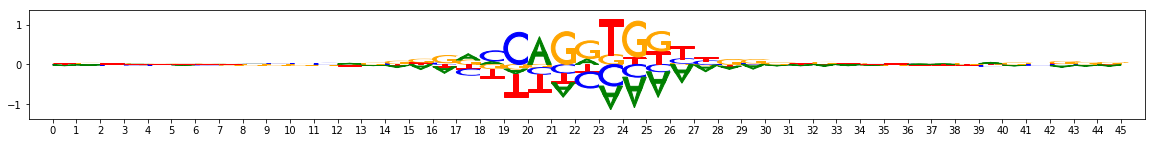

Task 2 actual importance scores:


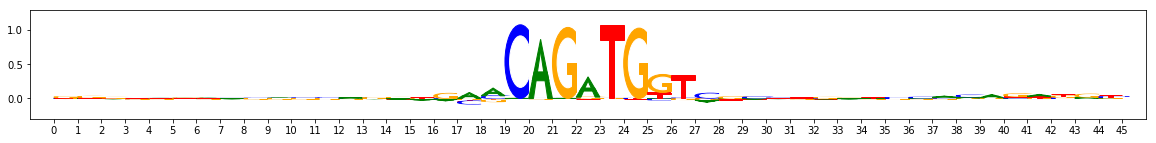

onehot, fwd and rev:


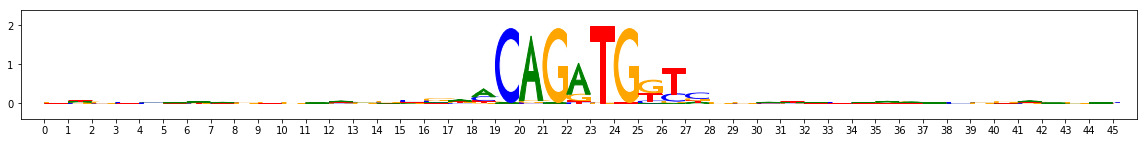

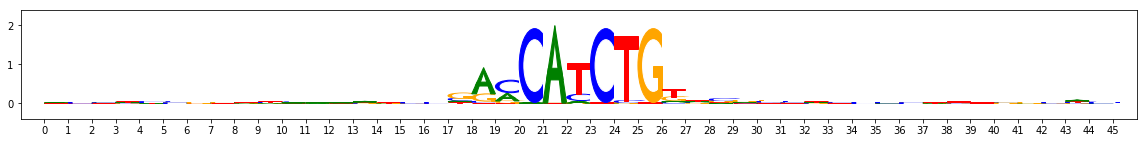

In [25]:
final_flank_to_add=10
final_postprocessor = aggregator.ExpandSeqletsToFillPattern(            
                        track_set=track_set,                    
                        flank_to_add=final_flank_to_add)
final_patterns = final_postprocessor(reassigned_patterns)
print("Got "+str(len(final_patterns))
      +" patterns after reassignment")

from modisco.visualization import viz_sequence

for pattern in final_patterns:

    print("Task 0 hypothetical scores:")
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
    print("Task 0 actual importance scores:")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
    print("Task 1 hypothetical scores:")
    viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"].fwd)
    print("Task 1 actual importance scores:")
    viz_sequence.plot_weights(pattern["task1_contrib_scores"].fwd)
    print("Task 2 hypothetical scores:")
    viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"].fwd)
    print("Task 2 actual importance scores:")
    viz_sequence.plot_weights(pattern["task2_contrib_scores"].fwd)
    print("onehot, fwd and rev:")
    background = np.array([0.27, 0.23, 0.23, 0.27])
    viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"].fwd),
                                                    background=background)) 
    viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"].rev),
                                                    background=background)) 

# Runing TF-MoDISco end-to-end

The code below demonstrates how to run TF-MoDISco end-to-end on all the metaclusters.

To showcase customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqelts. For a particular task, "significant" seqlets are identified by fitting a laplace distribution to the left and right tails of the values obtained after smoothing the importance scores with a window of size `sliding_window_size`. This laplace distribution is assumed to represent the null distribution of random seqlet importance scores. A threshold is then identified such that the false discovery rate (computed as the ratio of the expected number of seqlets according to the laplace null to the observed number of seqlets above the threshold) is less that `target_seqlet_fdr`. This is what is meant by "Est. FDR" printed in the logs below. If "Est. FDR" is above the target threshold, that means there was no significant increase in the number of seqlets relative to the null. You'll see below that "Est. FDR" for negative scores for any task is above this threshold, which fits with the simulation because there were no "negative set" motifs.

On task task0
Computing windowed sums
Computing threshold
peak(mu)= -0.024238264271989465
Mu: -2.423826e-02 +/- 5.063778e-06
Lablace_b: 0.15164182366673082 and 0.21323786117475912
Thresholds: -1.5073591825459152 and 1.2725672367122025
#fdrs pass: 0 and 19793
CDFs: 0.999943452031181 and 0.9977152471273854
Est. FDRs: 1.0 and 0.00999113540721059


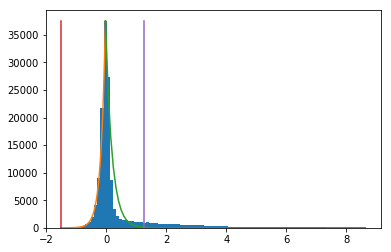

Got 1371 coords
On task task1
Computing windowed sums
Computing threshold
peak(mu)= 0.005545238786377013
Mu: 5.545239e-03 +/- 5.741705e-06
Lablace_b: 0.1412717956920302 and 0.11624143409064712
Thresholds: -1.7306354243224487 and 0.7122924130493775
#fdrs pass: 0 and 15512
CDFs: 0.9999954008918504 and 0.9977118086817763
Est. FDRs: 0.3727485624294786 and 0.009994167375583403


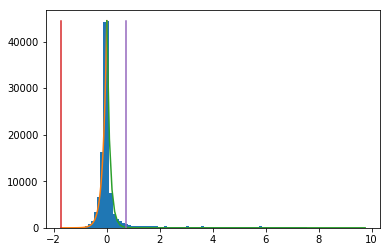

Got 1069 coords
On task task2
Computing windowed sums
Computing threshold
peak(mu)= -0.011790548293385654
Mu: -1.179055e-02 +/- 7.010704e-06
Lablace_b: 0.1150758068659872 and 0.12597872040434585
Thresholds: -1.625360642401967 and 0.7686457290961407
#fdrs pass: 0 and 16462
CDFs: 0.9999991864034751 and 0.9979603661115659
Est. FDRs: 0.05563206652232111 and 0.009964247323977026


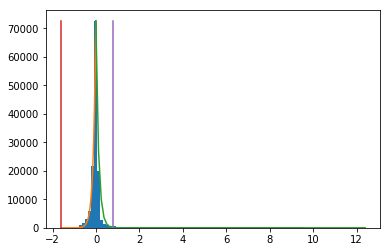

Got 1009 coords
After resolving overlaps, got 1966 seqlets
Across all tasks, the weakest laplace threshold used was: 0.9977118086817763
1966 identified in total
4 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [823, 668, 317, 158]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,1'}
On metacluster 3
Metacluster size 158
Relevant tasks:  ('task2',)
Relevant signs:  (1,)
(Round 1) num seqlets: 158
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.05 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calcul

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.9s finished


Louvain completed 200 runs in 7.40829491615 seconds
Wrote graph to binary file in 0.0119190216064 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.712738
After 3 runs, maximum modularity is Q = 0.72518
Louvain completed 53 runs in 4.60646796227 seconds
Preproc + Louvain took 12.0876269341 s
Got 7 clusters after round 1
Counts:
{0: 25, 1: 24, 2: 22, 3: 22, 4: 19, 5: 15, 6: 11}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 25 seqlets
Trimmed 2 out of 25
Skipped 3 seqlets
Aggregating for cluster 1 with 24 seqlets
Trimmed 4 out of 24
Aggregating for cluster 2 with 22 seqlets
Trimmed 6 out of 22
Aggregating for cluster 3 with 22 seqlets
Trimmed 0 out of 22
Skipped 5 seqlets
Aggregating for cluster 4 with 19 seqlets
Trimmed 1 out of 19
Skipped 1 seqlets
Aggregating for cluster 5 with 15 seqlets
Trimmed 4 out of 15
Skipped 1 seqlets
Aggregating for cluster 6 with 11 seqlets
Trimmed 1 out of 11
Skipped 1 seqlets
(Round 2) 

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.8s finished


Louvain completed 200 runs in 7.23116517067 seconds
Wrote graph to binary file in 0.00944805145264 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.670293
Louvain completed 51 runs in 4.381909132 seconds
Preproc + Louvain took 11.6839790344 s
Got 7 clusters after round 2
Counts:
{0: 30, 1: 30, 2: 19, 3: 12, 4: 8, 5: 7, 6: 3}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 30 seqlets
Trimmed 4 out of 30
Skipped 1 seqlets
Aggregating for cluster 1 with 30 seqlets
Trimmed 5 out of 30
Aggregating for cluster 2 with 19 seqlets
Trimmed 1 out of 19
Aggregating for cluster 3 with 12 seqlets
Trimmed 0 out of 12
Aggregating for cluster 4 with 8 seqlets
Trimmed 0 out of 8
Skipped 1 seqlets
Aggregating for cluster 5 with 7 seqlets
Trimmed 0 out of 7
Aggregating for cluster 6 with 3 seqlets
Trimmed 0 out of 3
Got 7 clusters
Splitting into subclusters...
Merging on 7 clusters
On merging iteration 1
Computing pattern to seqlet dist

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.6s finished


Louvain completed 200 runs in 7.18348097801 seconds
Wrote graph to binary file in 0.0407781600952 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.653022
Louvain completed 51 runs in 4.33554911613 seconds
Preproc + Louvain took 11.6372539997 s
Got 5 clusters after round 1
Counts:
{0: 52, 1: 48, 2: 46, 3: 42, 4: 41}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 52 seqlets
Trimmed 8 out of 52
Aggregating for cluster 1 with 48 seqlets
Trimmed 3 out of 48
Skipped 4 seqlets
Aggregating for cluster 2 with 46 seqlets
Trimmed 7 out of 46
Skipped 6 seqlets
Aggregating for cluster 3 with 42 seqlets
Trimmed 1 out of 42
Skipped 10 seqlets
Aggregating for cluster 4 with 41 seqlets
Trimmed 6 out of 41
Skipped 2 seqlets
(Round 2) num seqlets: 180
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.04 s
Starting affinity matrix computations
Normalization comput

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.6s finished


Louvain completed 200 runs in 7.18707799911 seconds
Wrote graph to binary file in 0.0171408653259 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.725445
After 2 runs, maximum modularity is Q = 0.726125
After 5 runs, maximum modularity is Q = 0.737277
Louvain completed 55 runs in 4.86324906349 seconds
Preproc + Louvain took 12.1476080418 s
Got 10 clusters after round 2
Counts:
{0: 34, 1: 28, 2: 25, 3: 25, 4: 21, 5: 15, 6: 14, 7: 10, 8: 6, 9: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 34 seqlets
Trimmed 3 out of 34
Aggregating for cluster 1 with 28 seqlets
Trimmed 2 out of 28
Aggregating for cluster 2 with 25 seqlets
Trimmed 0 out of 25
Aggregating for cluster 3 with 25 seqlets
Trimmed 0 out of 25
Aggregating for cluster 4 with 21 seqlets
Trimmed 0 out of 21
Aggregating for cluster 5 with 15 seqlets
Trimmed 1 out of 15
Aggregating for cluster 6 with 14 seqlets
Trimmed 2 out of 14
Aggregating for cluster 7 with

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.7s finished


Louvain completed 200 runs in 7.42958188057 seconds
Wrote graph to binary file in 0.0479791164398 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.721197
After 23 runs, maximum modularity is Q = 0.722321
Louvain completed 73 runs in 6.63682508469 seconds
Preproc + Louvain took 14.2062110901 s
Got 8 clusters after round 1
Counts:
{0: 55, 1: 50, 2: 47, 3: 38, 4: 33, 5: 31, 6: 30, 7: 25}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 55 seqlets
Trimmed 4 out of 55
Skipped 3 seqlets
Aggregating for cluster 1 with 50 seqlets
Trimmed 0 out of 50
Skipped 4 seqlets
Aggregating for cluster 2 with 47 seqlets
Trimmed 1 out of 47
Skipped 5 seqlets
Aggregating for cluster 3 with 38 seqlets
Trimmed 2 out of 38
Skipped 3 seqlets
Aggregating for cluster 4 with 33 seqlets
Trimmed 11 out of 33
Skipped 3 seqlets
Aggregating for cluster 5 with 31 seqlets
Trimmed 2 out of 31
Skipped 3 seqlets
Aggregating for cluster 6 with 30 seqlets
Tr

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.3s finished


Louvain completed 200 runs in 7.84108686447 seconds
Wrote graph to binary file in 0.028352022171 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.737015
After 10 runs, maximum modularity is Q = 0.738132
Louvain completed 60 runs in 5.61116600037 seconds
Preproc + Louvain took 13.5638830662 s
Got 11 clusters after round 2
Counts:
{0: 44, 1: 34, 2: 29, 3: 28, 4: 25, 5: 23, 6: 18, 7: 17, 8: 17, 9: 13, 10: 13}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 44 seqlets
Trimmed 0 out of 44
Aggregating for cluster 1 with 34 seqlets
Trimmed 0 out of 34
Aggregating for cluster 2 with 29 seqlets
Trimmed 0 out of 29
Aggregating for cluster 3 with 28 seqlets
Trimmed 1 out of 28
Aggregating for cluster 4 with 25 seqlets
Trimmed 1 out of 25
Aggregating for cluster 5 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 6 with 18 seqlets
Trimmed 2 out of 18
Aggregating for cluster 7 with 17 seqlets
Trimmed 1 out of 17
Aggrega

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.5s finished


Louvain completed 200 runs in 8.25870800018 seconds
Wrote graph to binary file in 0.0557949542999 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.600895
After 21 runs, maximum modularity is Q = 0.609496
Louvain completed 71 runs in 6.64446115494 seconds
Preproc + Louvain took 15.0595080853 s
Got 7 clusters after round 1
Counts:
{0: 129, 1: 74, 2: 51, 3: 48, 4: 34, 5: 34, 6: 11}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 129 seqlets
Trimmed 4 out of 129
Skipped 10 seqlets
Aggregating for cluster 1 with 74 seqlets
Trimmed 0 out of 74
Skipped 8 seqlets
Aggregating for cluster 2 with 51 seqlets
Trimmed 4 out of 51
Skipped 3 seqlets
Aggregating for cluster 3 with 48 seqlets
Trimmed 4 out of 48
Skipped 3 seqlets
Aggregating for cluster 4 with 34 seqlets
Trimmed 2 out of 34
Skipped 3 seqlets
Aggregating for cluster 5 with 34 seqlets
Trimmed 0 out of 34
Skipped 7 seqlets
Aggregating for cluster 6 with 11 seqlets
Trimme

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.2s finished


Louvain completed 200 runs in 7.9764559269 seconds
Wrote graph to binary file in 0.0439541339874 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.635469
After 2 runs, maximum modularity is Q = 0.636763
After 37 runs, maximum modularity is Q = 0.652556
Louvain completed 87 runs in 8.15231204033 seconds
Preproc + Louvain took 16.2633211613 s
Got 7 clusters after round 2
Counts:
{0: 117, 1: 50, 2: 44, 3: 42, 4: 30, 5: 23, 6: 19}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 117 seqlets
Trimmed 1 out of 117
Aggregating for cluster 1 with 50 seqlets
Trimmed 3 out of 50
Aggregating for cluster 2 with 44 seqlets
Trimmed 0 out of 44
Aggregating for cluster 3 with 42 seqlets
Trimmed 0 out of 42
Aggregating for cluster 4 with 30 seqlets
Trimmed 4 out of 30
Aggregating for cluster 5 with 23 seqlets
Trimmed 1 out of 23
Aggregating for cluster 6 with 19 seqlets
Trimmed 0 out of 19
Got 7 clusters
Splitting into subclusters...
In

In [26]:
import modisco.tfmodisco_workflow.workflow

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.01,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)


## Save and print the results

In [27]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


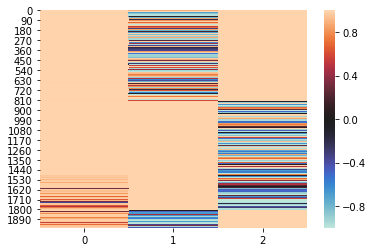

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 263
Task 0 hypothetical scores:


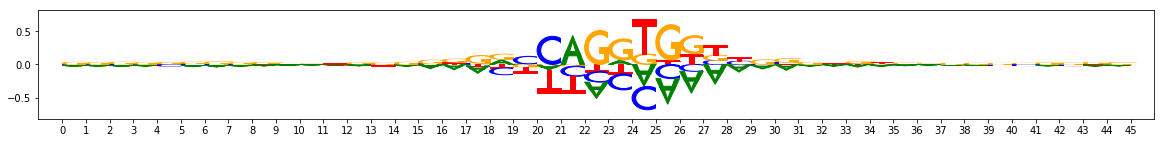

Task 0 actual importance scores:


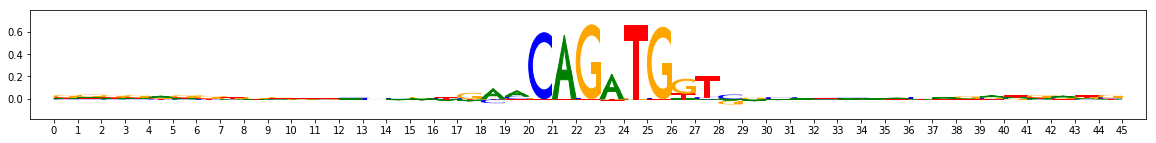

Task 1 hypothetical scores:


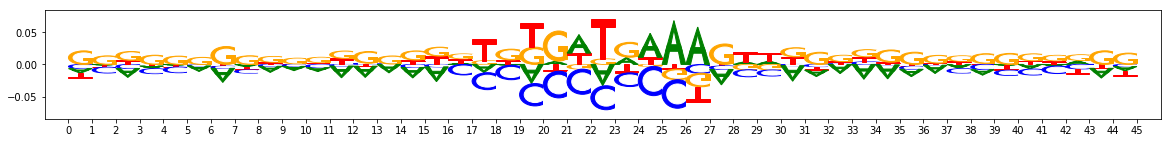

Task 1 actual importance scores:


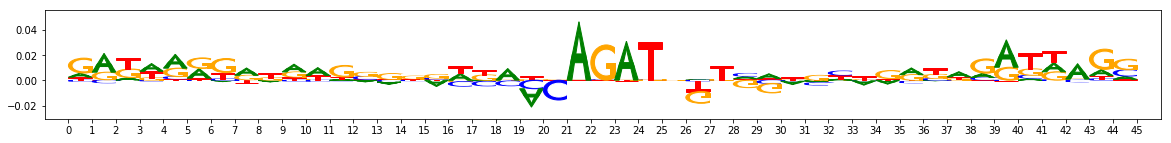

Task 2 hypothetical scores:


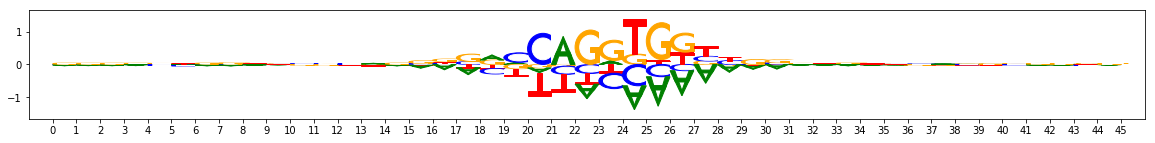

Task 2 actual importance scores:


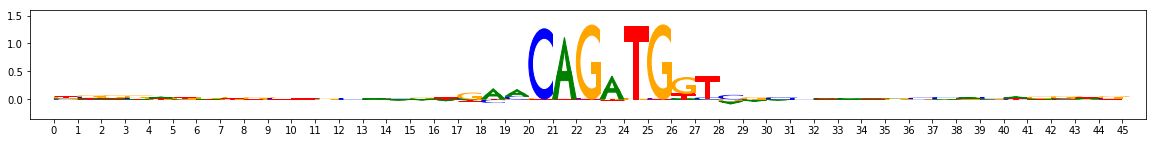

onehot, fwd and rev:


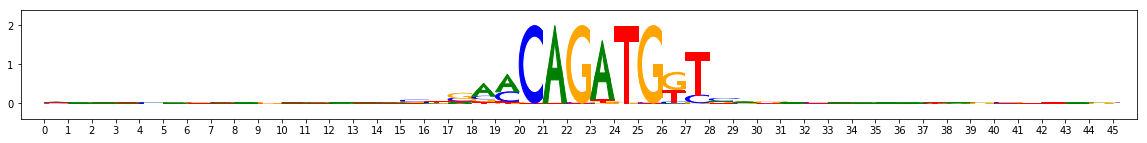

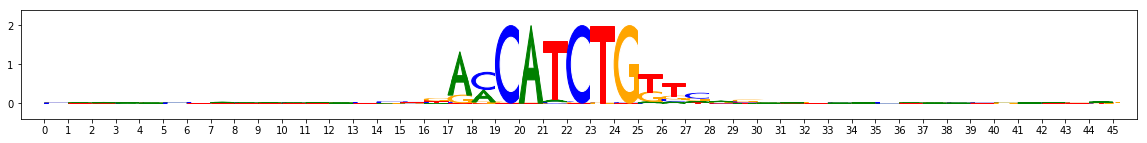

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 214
Task 0 hypothetical scores:


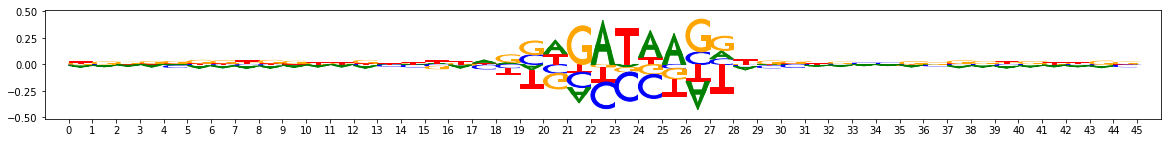

Task 0 actual importance scores:


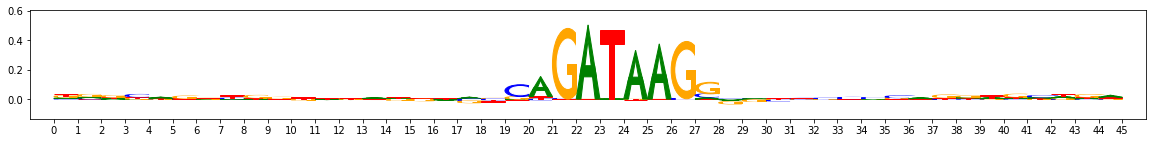

Task 1 hypothetical scores:


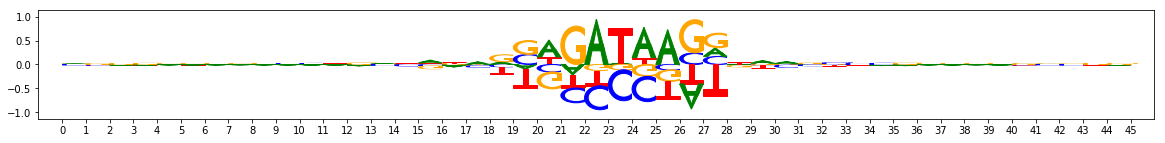

Task 1 actual importance scores:


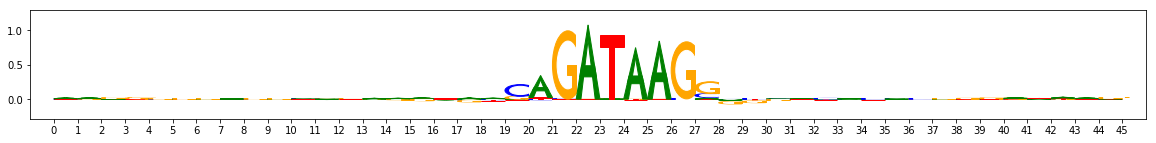

Task 2 hypothetical scores:


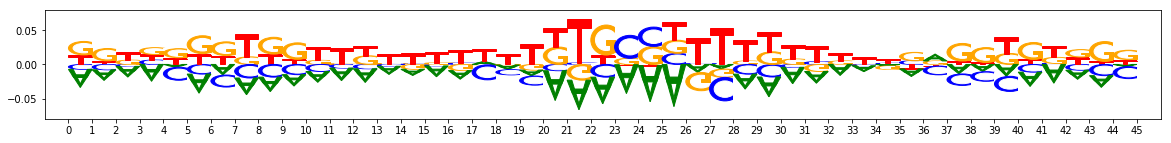

Task 2 actual importance scores:


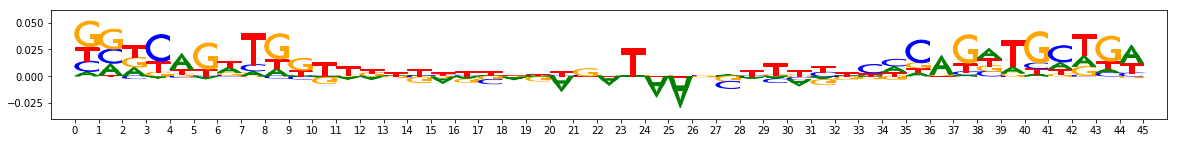

onehot, fwd and rev:


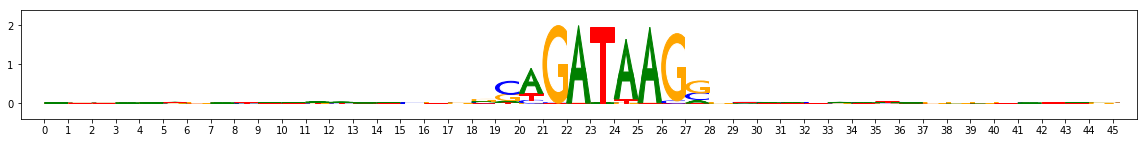

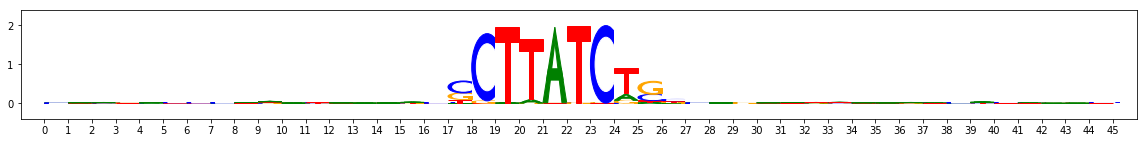

metacluster_2
activity pattern: [0 1 0]
metacluster_2 pattern_0
total seqlets: 148
Task 0 hypothetical scores:


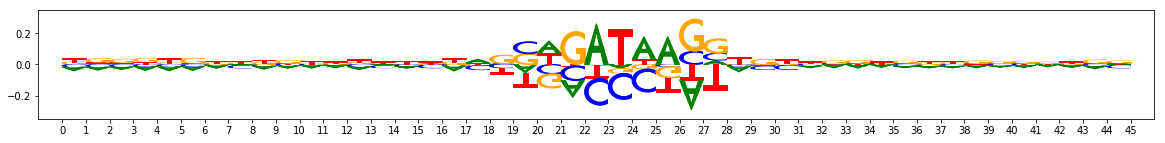

Task 0 actual importance scores:


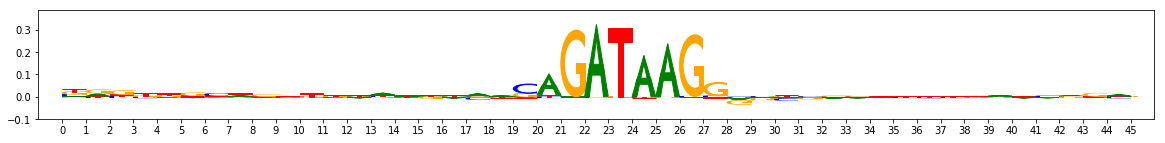

Task 1 hypothetical scores:


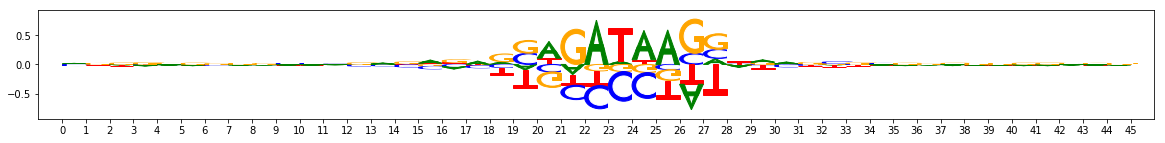

Task 1 actual importance scores:


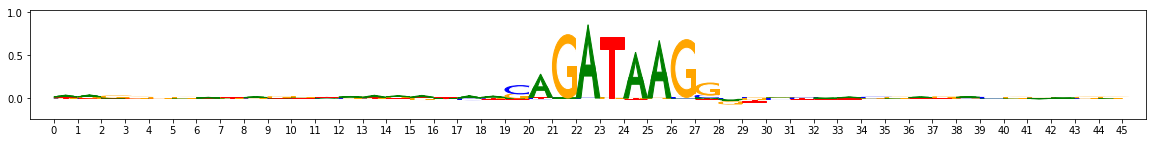

Task 2 hypothetical scores:


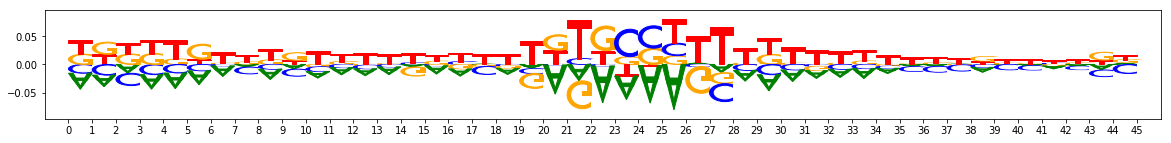

Task 2 actual importance scores:


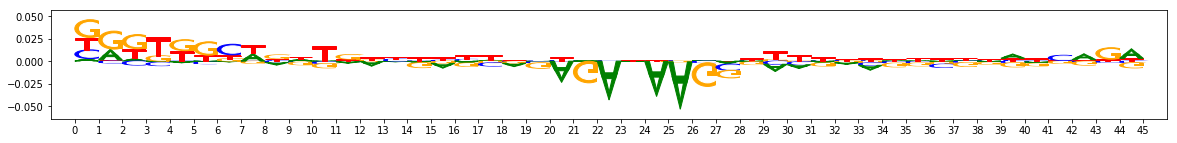

onehot, fwd and rev:


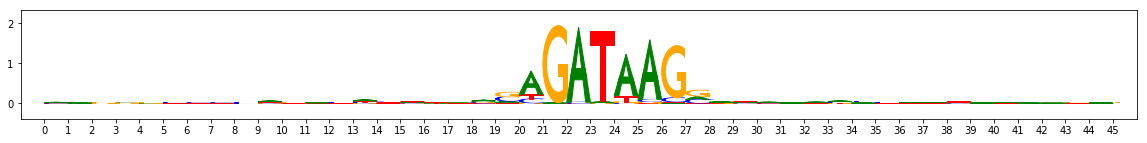

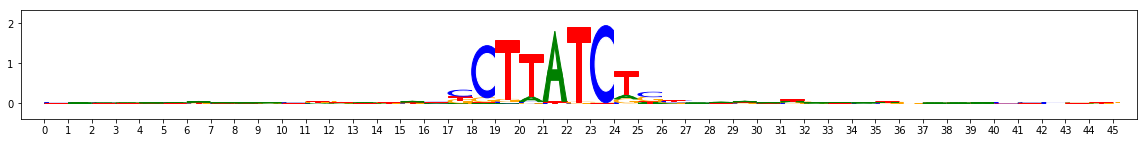

metacluster_3
activity pattern: [0 0 1]
metacluster_3 pattern_0
total seqlets: 81
Task 0 hypothetical scores:


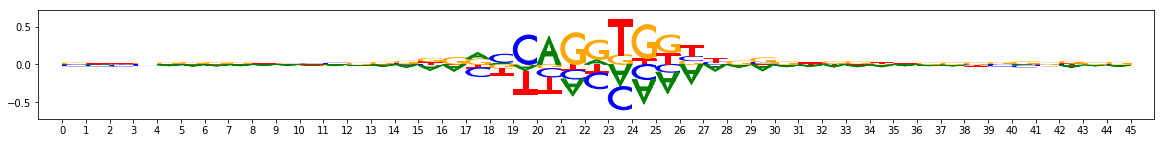

Task 0 actual importance scores:


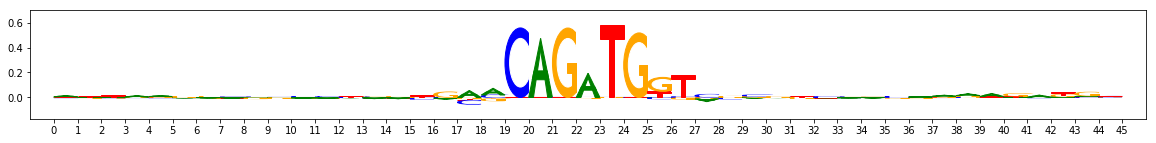

Task 1 hypothetical scores:


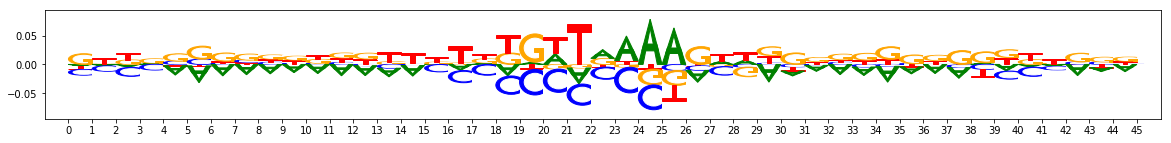

Task 1 actual importance scores:


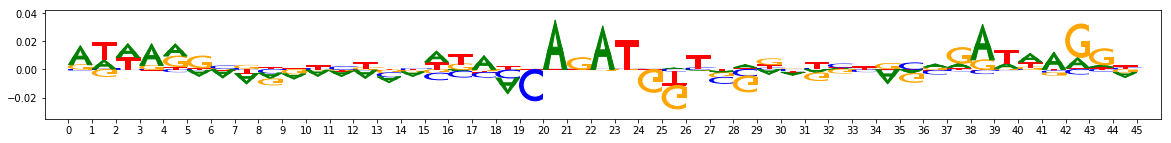

Task 2 hypothetical scores:


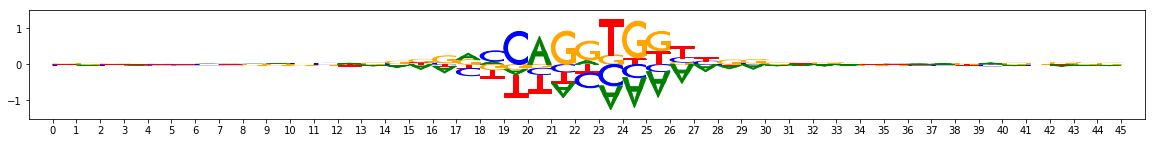

Task 2 actual importance scores:


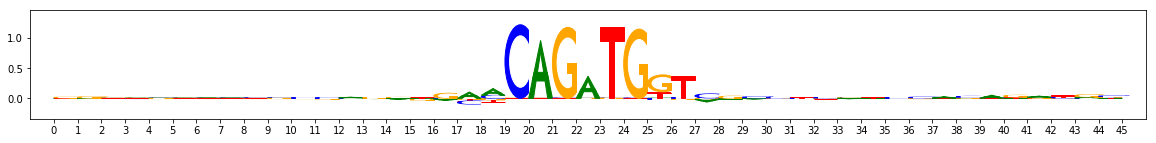

onehot, fwd and rev:


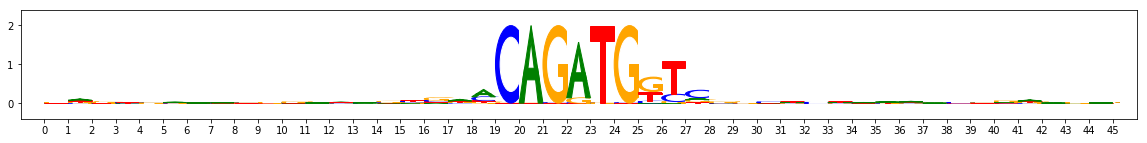

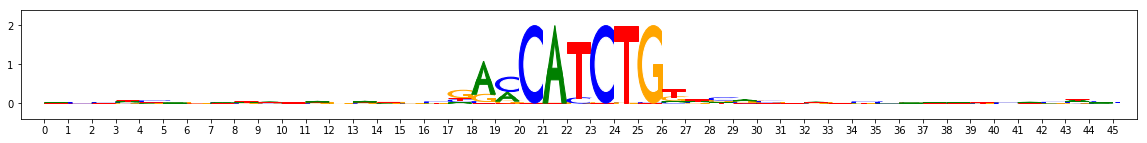

In [28]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()